<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>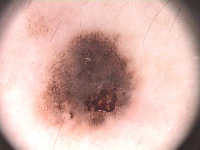</td><td>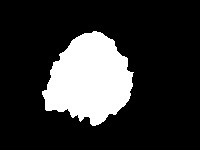</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# ссылка на дропбокс постоянно ломалась, использовал гугл диск со скаченным датасетом

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget -c https://www.dropbox.com/s/1cii0sgkcgu534k/PH2Dataset.rar

In [ ]:
!ls

drive  sample_data


In [ ]:
get_ipython().system_raw("unrar x /content/drive/MyDrive/DLS/PH2Dataset.rar")

In [ ]:
#get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.pooling import MaxPool2d
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from skimage.transform import resize
from skimage.io import imread
import torchvision
import numpy as np
from torch.nn import BCEWithLogitsLoss
from torchvision import transforms
from torch._C import PyTorchFileReader
import pickle as pkl
from scipy.ndimage import distance_transform_edt as distance_transform
import os
import seaborn as sns
import pandas as pd
import gc

rcParams['figure.figsize'] = (15,4)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [ ]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

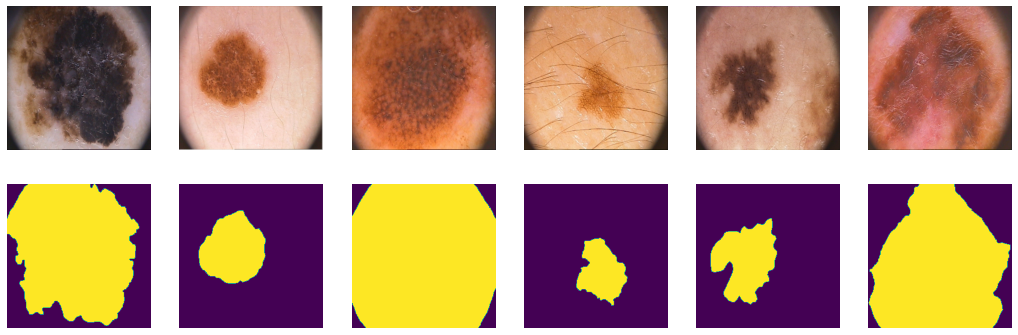

In [ ]:
# добавим в выбор изображений рандом
plt.figure(figsize=(18, 6))
for i in range(6):
    j = np.random.randint(0, 200)
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:

batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

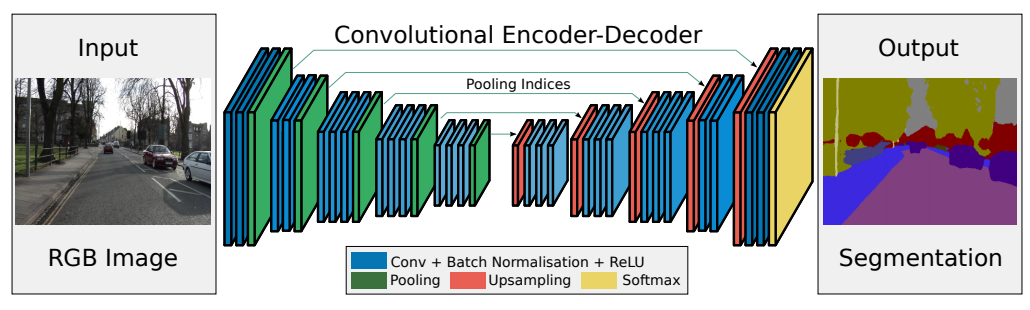

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
# реализация SegNet без bottleneck и с использованием MaxUnpool
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # заменим bottleneck на дополнительный слой как на схеме выше
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # decoder
        # Unpooling
        self.unpool0 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )

        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256

        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool, id_0 = self.pool0(e0)

        e1 = self.enc_conv1(e0_pool)
        e1_pool, id_1 = self.pool1(e1)

        e2 = self.enc_conv2(e1_pool)
        e2_pool, id_2 = self.pool2(e2)

        e3 = self.enc_conv3(e2_pool)
        e3_pool, id_3 = self.pool3(e3)

        e4 = self.enc_conv4(e3_pool)
        e4_pool, id_4 = self.pool3(e4)

        # decoder
        d0_unpool = self.unpool0(e4_pool, id_4)
        d0 = self.dec_conv0(d0_unpool)

        d1_unpool = self.unpool1(d0, id_3)
        d1 = self.dec_conv1(d1_unpool)

        d2_unpool = self.unpool2(d1, id_2)
        d2 = self.dec_conv2(d2_unpool)

        d3_unpool = self.unpool3(d2, id_1)
        d3 = self.dec_conv3(d3_unpool)

        d4_unpool = self.unpool4(d3, id_0)
        d4 = self.dec_conv4(d4_unpool)

        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratcheal
    return (torch.maximum(y_pred, torch.zeros_like(y_pred)) - \
            y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()

In [ ]:
# сравним встроенную функцию с нашей
torch_f =  BCEWithLogitsLoss()
a = torch.randn(128,1,64,64)
b = torch.randn(128,1,64,64)
bce_loss(a, b), torch_f(a, b)

(tensor(0.8045), tensor(0.8041))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler):
    X_val, Y_val = next(iter(data_val))

    train_losses = []
    val_losses = []
    scores = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        model.train()  # train mode
        avg_loss = 0
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass

            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        train_losses.append(avg_loss.detach().cpu())

        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        avg_loss_val = 0
        with torch.no_grad():
            Y_hat = torch.sigmoid(model(X_val.to(device)).detach().cpu()) # detach and put into cpu
            for X_batch, Y_batch in data_val:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                outp = model(X_batch)
                loss_val = loss_fn(Y_batch, outp)
                avg_loss_val += loss_val / len(data_val)
            val_losses.append(avg_loss_val)
            score = score_model(model, iou_pytorch, data_val)
            scores.append(score)

        scheduler.step()

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(20, 8))
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Validation')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    del Y_hat
    del X_batch
    del Y_batch
    del Y_pred
    del opt
    del outp
    del score
    del loss
    del X_val
    del Y_val
    torch.cuda.empty_cache()
    gc.collect()

    return train_losses, val_losses, scores

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_batch = Y_label.to(device)
        Y_pred = torch.sigmoid(model(X_batch)) > 0.5
        scores += (metric(Y_pred, Y_label.to(device)).mean().item()) / len(data)

    del X_batch
    del Y_label
    del Y_pred
    torch.cuda.empty_cache()

    return scores

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model_segnet_BCE = SegNet().to(device)

In [ ]:
models = []

In [ ]:
models.append(model_segnet_BCE)

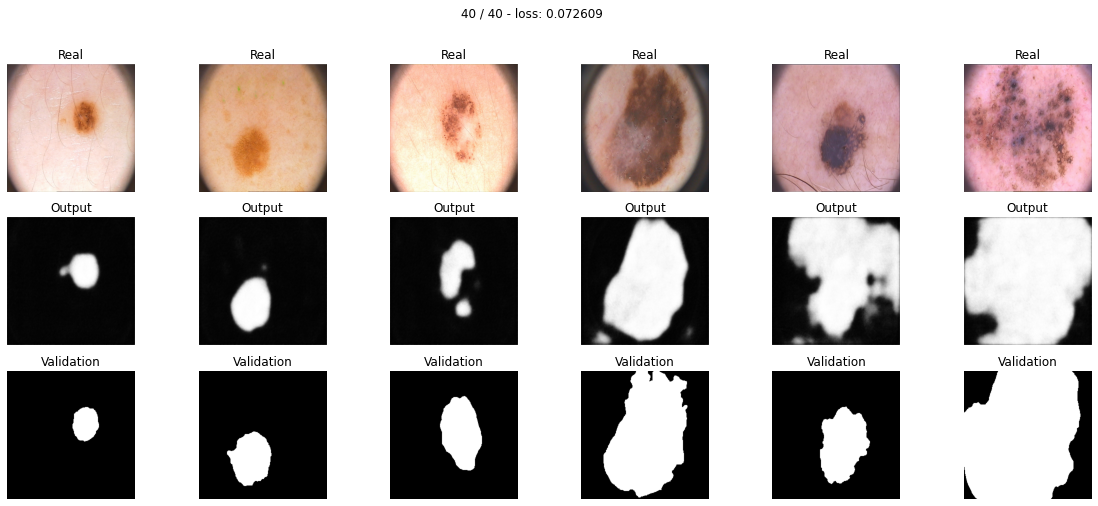

In [ ]:
# будем использовать 40 эпох и одинаковые гиперпараметры для всех моделей
# и функций потерь

max_epochs = 40

optimaizer = torch.optim.Adam(model_segnet_BCE.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_segnet_BCE, val_loss_segnet_BCE, scores_segnet_BCE = train(
    model_segnet_BCE, optimaizer, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
def loss_transform(tr_loss, valid_loss):
    train_loss = torch.tensor(tr_loss, dtype=torch.float32)
    val_loss = torch.tensor(valid_loss, dtype=torch.float32)
    train_loss = train_loss.view(train_loss.shape[0],1)
    val_loss = val_loss.view(val_loss.shape[0],1)
    return train_loss, val_loss

In [ ]:
train_loss, val_loss = loss_transform(train_loss_segnet_BCE, val_loss_segnet_BCE)

После тренировки модели с определенной функцией потерь, отслеживать качество обучения будем с помощью графиков функции потерь на тренировочной и валидационной части датасета, также построим график 'score' по валидационной выборке.

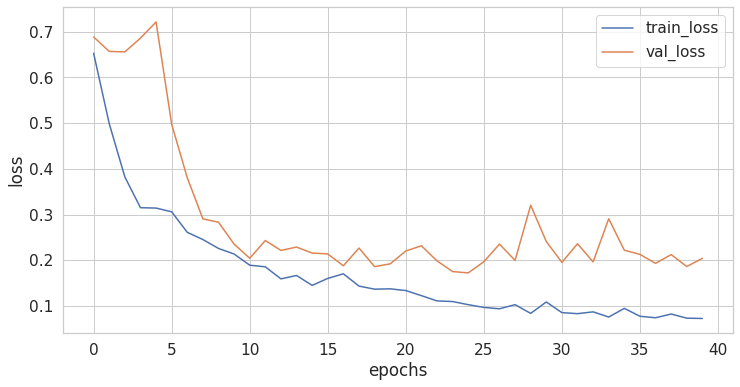

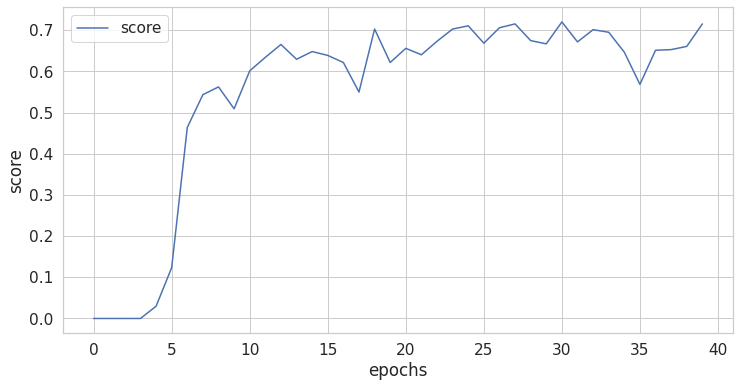

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_segnet_BCE, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_BCE_seg = score_model(model_segnet_BCE, iou_pytorch, data_val)
score_BCE_seg

0.6390625163912773

In [ ]:
models_score = pd.DataFrame({'name': ['Segnet', 'UNet', 'UNet2'],
                             'BCELoss_score': [0, 0, 0],
                             'DiceLoss_score': [0, 0, 0],
                             'FocalLoss_score': [0, 0, 0],
                             'DiceBLoss_score': [0, 0, 0]})
models_score.loc[0, 'BCELoss_score'] = score_BCE_seg
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063               0                0                0
1    UNet       0.000000               0                0                0
2   UNet2       0.000000               0                0                0

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


### **1. Dice coefficient**
 Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
# реализуем dice loss
def dice_loss(y_real, y_pred):
    smooth = 1e-8
    y_real = y_real.squeeze(1)
    y_pred = y_pred.squeeze(1)
    probs = torch.sigmoid(y_pred)
    num = (2. * y_real * probs).sum((1, 2))
    den = (y_real + probs).sum((1, 2))
    res = (num + smooth) / (den + smooth)
    res = 1 - res.sum() / y_real.size(0)

    return res

Проводим тестирование:

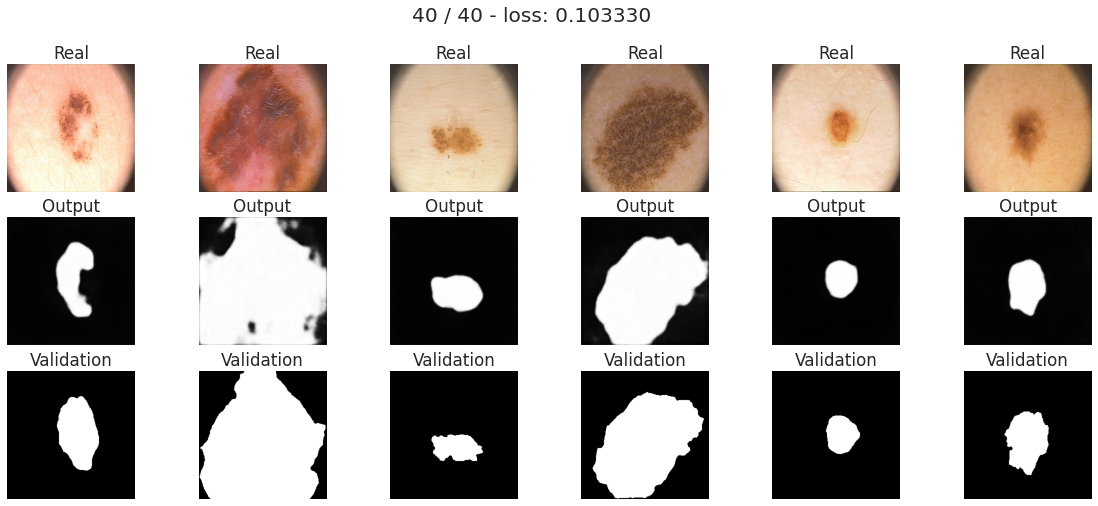

In [ ]:
model_segnet_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_segnet_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_dice_seg, val_loss_dice_seg, score_dice_seg = train(
    model_segnet_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_segnet_dice)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_dice_seg, val_loss_dice_seg)

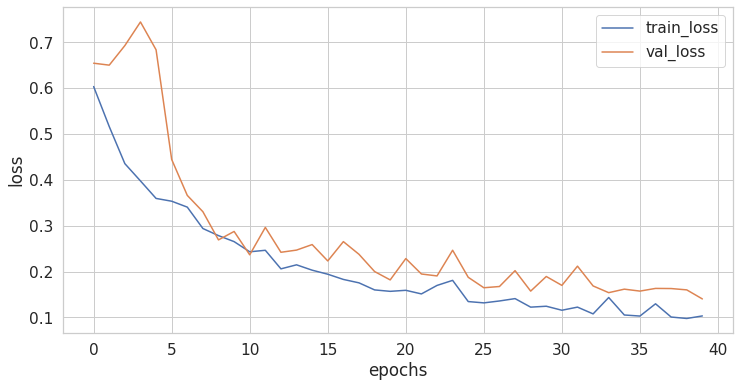

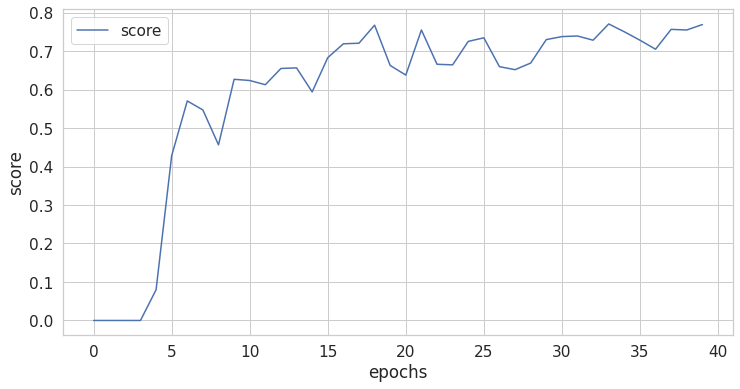

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(score_dice_seg, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_dice_seg = score_model(model_segnet_dice, iou_pytorch, data_val)
score_dice_seg

0.7578125149011612

In [ ]:
models_score.loc[0, 'DiceLoss_score'] = score_dice_seg
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813                0                0
1    UNet       0.000000        0.000000                0                0
2   UNet2       0.000000        0.000000                0                0

### [2. Focal loss:](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    y_pred  = y_pred.contiguous().view(y_pred .shape[0], -1)
    y_real = y_real.contiguous().view(y_real .shape[0], -1)
    gamma = 2
    loss = -((1 - y_pred)**gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)).mean()
    return loss

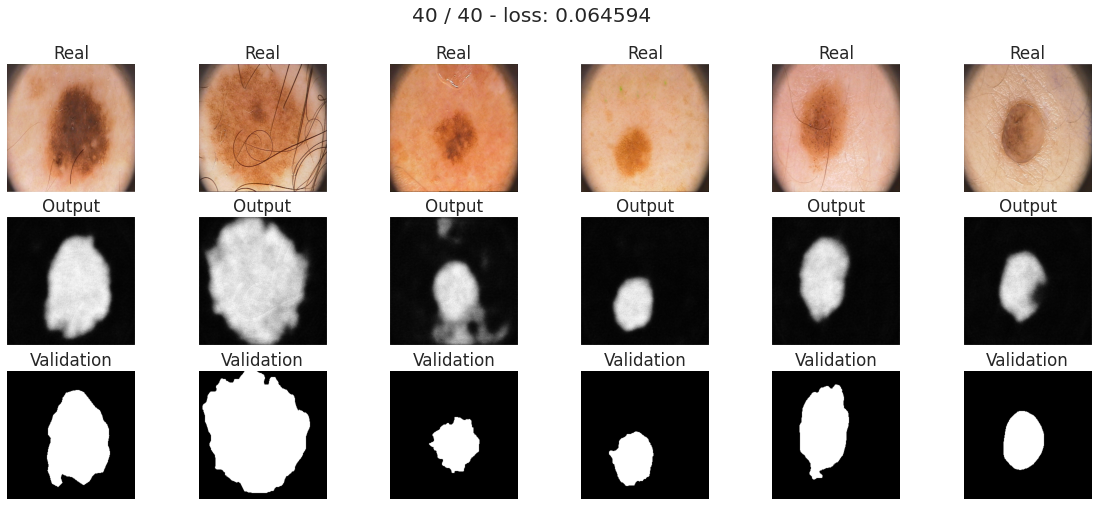

In [ ]:
model_focal_seg = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal_seg.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_focal_seg, val_loss_focal_seg, scores_focal_seg = train(model_focal_seg, optimaizer, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_focal_seg)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_focal_seg, val_loss_focal_seg)

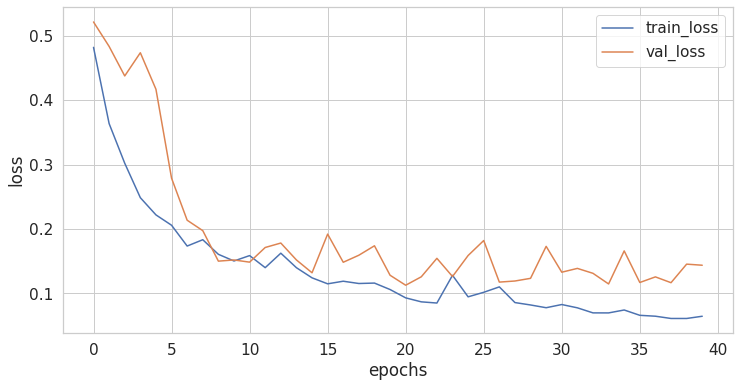

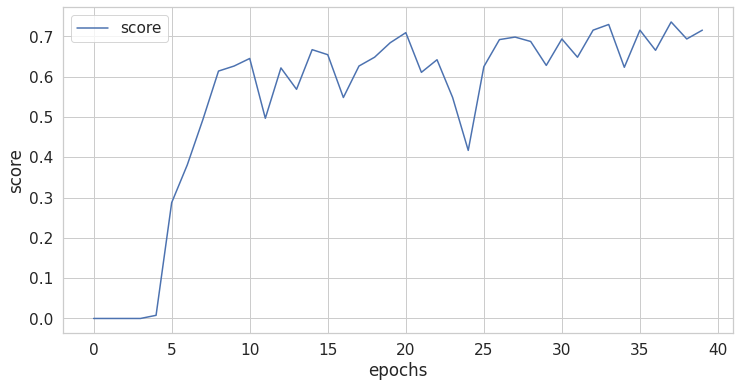

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_focal_seg, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_focal_seg = score_model(model_focal_seg, iou_pytorch, data_val)
score_focal_seg

0.6281250193715096

In [ ]:
models_score.loc[0, 'FocalLoss_score'] = score_focal_seg
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125                0
1    UNet       0.000000        0.000000         0.000000                0
2   UNet2       0.000000        0.000000         0.000000                0

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### **1. Dice boundary loss**

In [ ]:
def dice_boundary_loss(y_real, y_pred, alpha=0.01):
    y_real = y_real.squeeze(1)
    y_pred = y_pred.squeeze(1)
    probs = torch.sigmoid(y_pred)
    preds = probs > 0.5

    foreground_map = - distance_transform(y_real.cpu())
    background_map = distance_transform((1 - y_real).cpu())
    dist_map = torch.tensor(background_map + foreground_map).to(device)

    boundary_loss = ((dist_map * preds).sum((1, 2)) / 256 / 256).mean()

    smooth = 1e-8
    num = (2. * y_real * probs).sum((1, 2))
    den = (y_real + probs).sum((1, 2))
    dice = (num + smooth) / (den + smooth)
    dice = 1 - dice.sum() / y_real.size(0)

    return (1 - alpha) * dice + alpha * boundary_loss

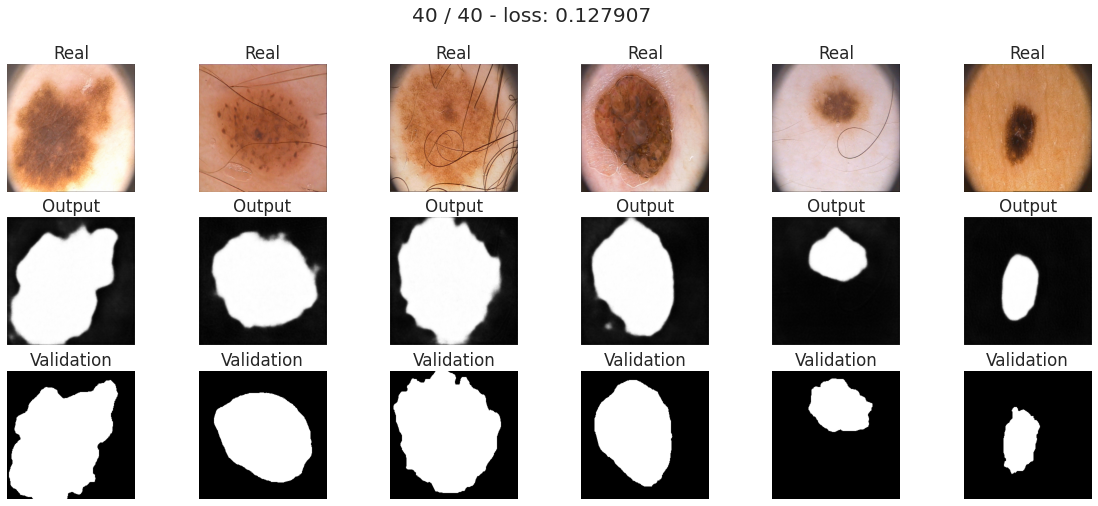

In [ ]:
dice_boundary_segnet = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(dice_boundary_segnet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_dice_boundary_loss_seg, val_dice_boundary_loss_seg, scores_dice_boundary = train(
    dice_boundary_segnet, optimaizer,
    dice_boundary_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(dice_boundary_segnet)

In [ ]:
train_loss, val_loss = loss_transform(train_dice_boundary_loss_seg, val_dice_boundary_loss_seg)

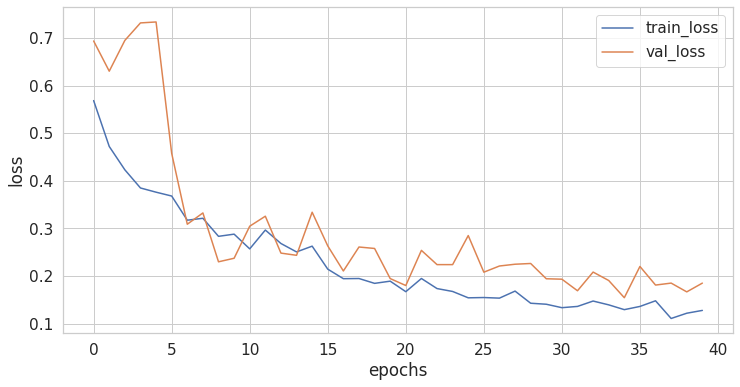

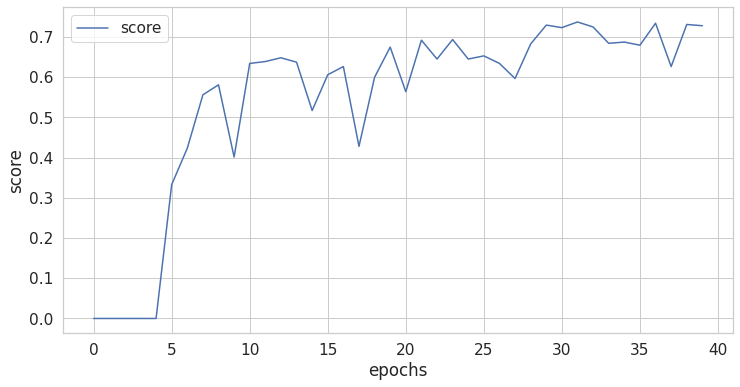

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_dice_boundary, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_diceBound_seg = score_model(dice_boundary_segnet, iou_pytorch, data_val)
score_diceBound_seg

0.6843750178813934

In [ ]:
models_score.loc[0, 'DiceBLoss_score'] = score_diceBound_seg
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.000000        0.000000         0.000000         0.000000
2   UNet2       0.000000        0.000000         0.000000         0.000000

----------------------------------------------------------------------------

-------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

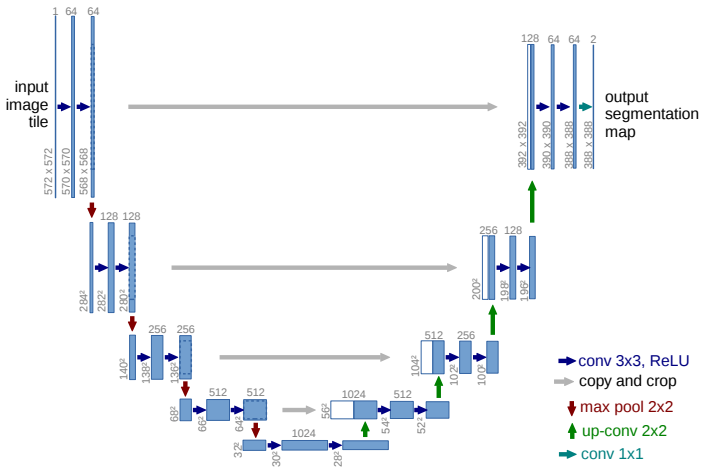

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(        self.double_conv = nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool0 = MaxPool2d(2, 2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool1 = MaxPool2d(2, 2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool2 = MaxPool2d(2, 2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool3 = MaxPool2d(2, 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64

        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2) # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(p3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3


### **Unet BCELoss**

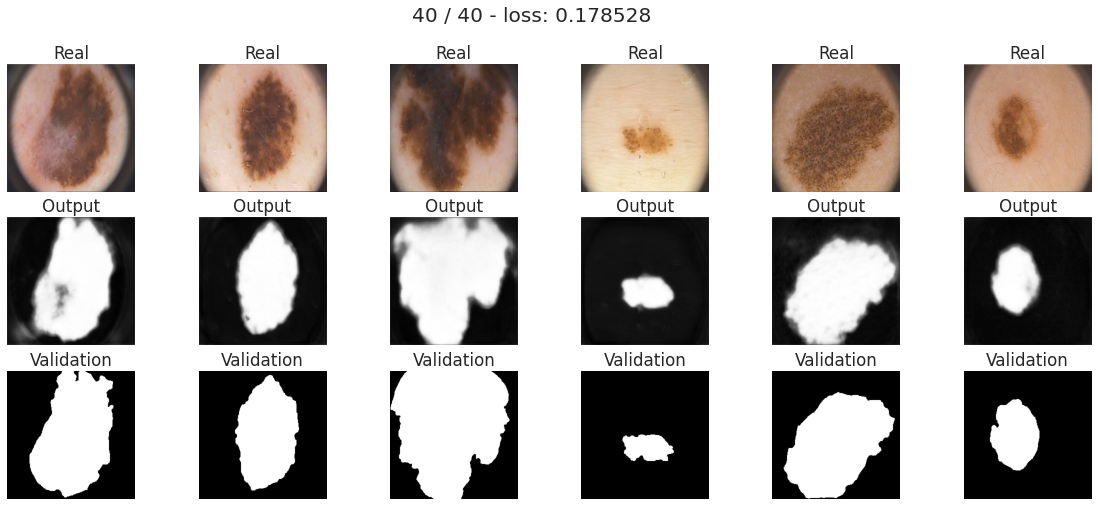

In [ ]:
model_Unet_BCE = UNet().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet_BCE.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_bce_Unet, val_loss_bce_Unet, scores_bce_Unet = train(model_Unet_BCE, optimaizer, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet_BCE)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_bce_Unet, val_loss_bce_Unet)

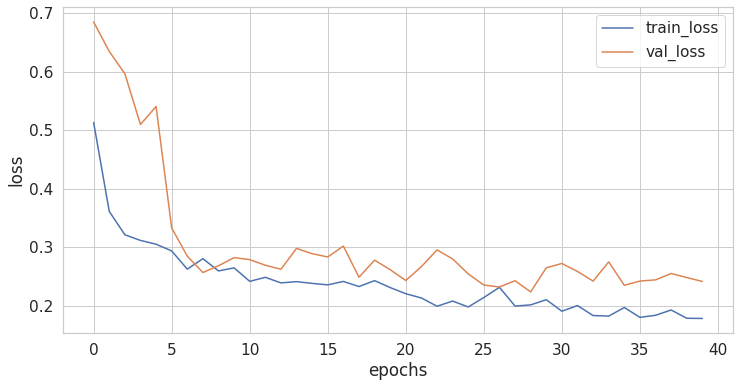

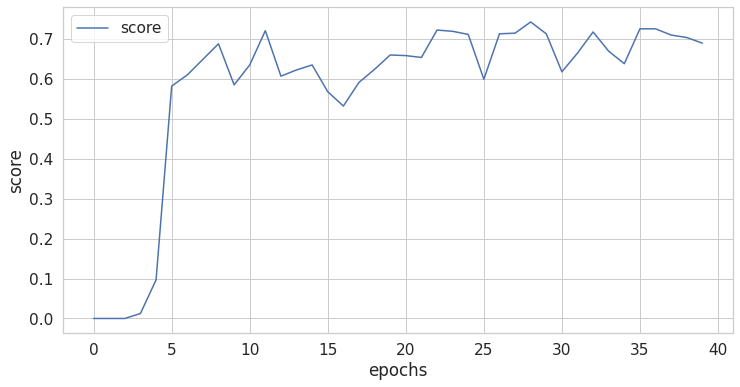

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_bce_Unet, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_BCE_Unet = score_model(model_Unet_BCE, iou_pytorch, data_val)
score_BCE_Unet

0.6140625104308128

In [ ]:
models_score.loc[1, 'BCELoss_score'] = score_BCE_Unet
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.000000         0.000000         0.000000
2   UNet2       0.000000        0.000000         0.000000         0.000000

### **Unet Dice coefficient**

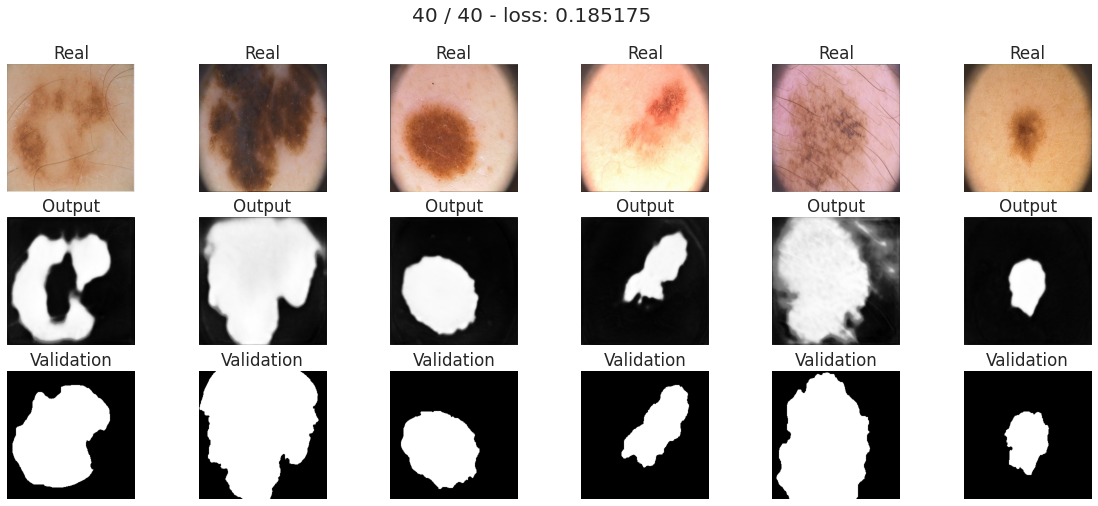

In [ ]:
model_Unet_dice = UNet().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_dice_Unet, val_loss_dice_Unet, scores_dice_Unet = train(
    model_Unet_dice, optimaizer, dice_loss,
     max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet_dice)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_dice_Unet, val_loss_dice_Unet)

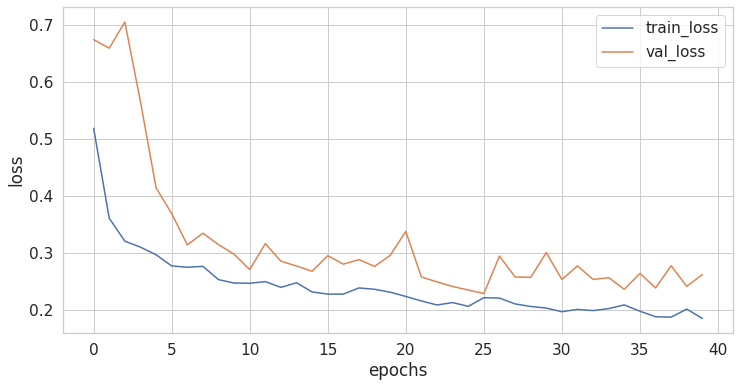

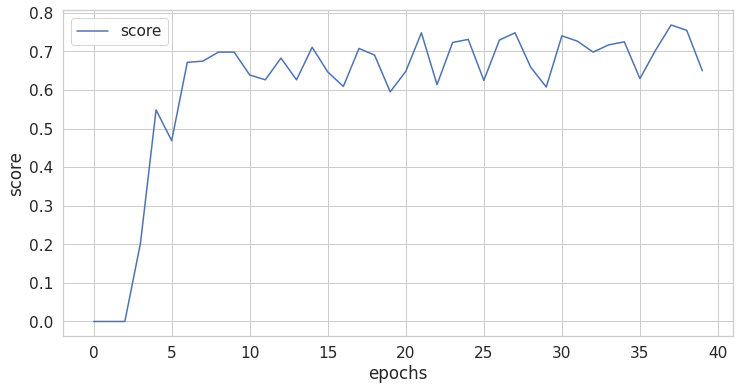

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_dice_Unet, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_dice_Unet = score_model(model_Unet_dice, iou_pytorch, data_val)
score_dice_Unet

0.6937500387430191

In [ ]:
models_score.loc[1, 'DiceLoss_score'] = score_dice_Unet
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.000000         0.000000
2   UNet2       0.000000        0.000000         0.000000         0.000000

### **Unet Focal loss**

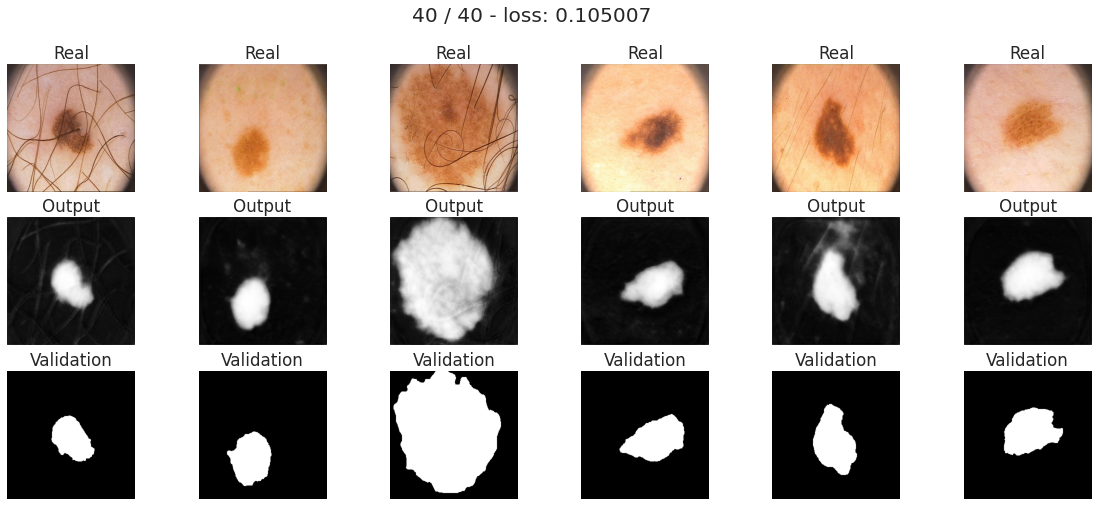

In [ ]:
model_Unet_focal = UNet().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_focal_Unet, val_loss_focal_Unet, scores_focal_Unet = train(
    model_Unet_focal, optimaizer, focal_loss,
     max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet_focal)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_focal_Unet, val_loss_focal_Unet)

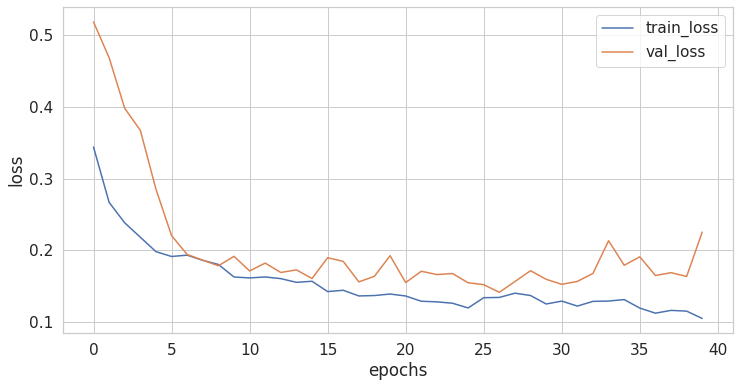

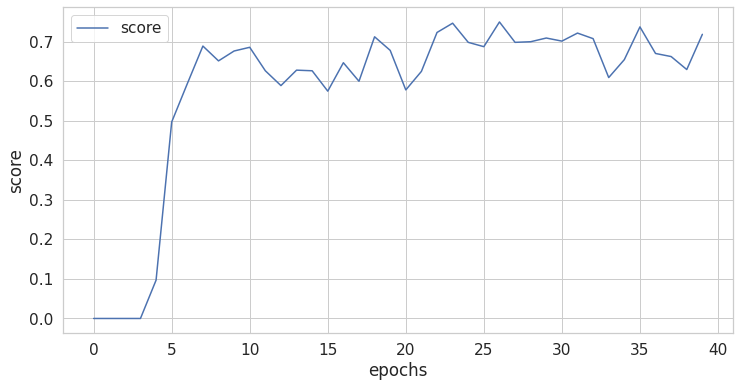

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_focal_Unet, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_focal_Unet = score_model(model_Unet_focal, iou_pytorch, data_val)
score_focal_Unet

0.7296874970197678

In [ ]:
models_score.loc[1, 'FocalLoss_score'] = score_focal_Unet
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.729687         0.000000
2   UNet2       0.000000        0.000000         0.000000         0.000000

### **Unet Dice boundary loss**

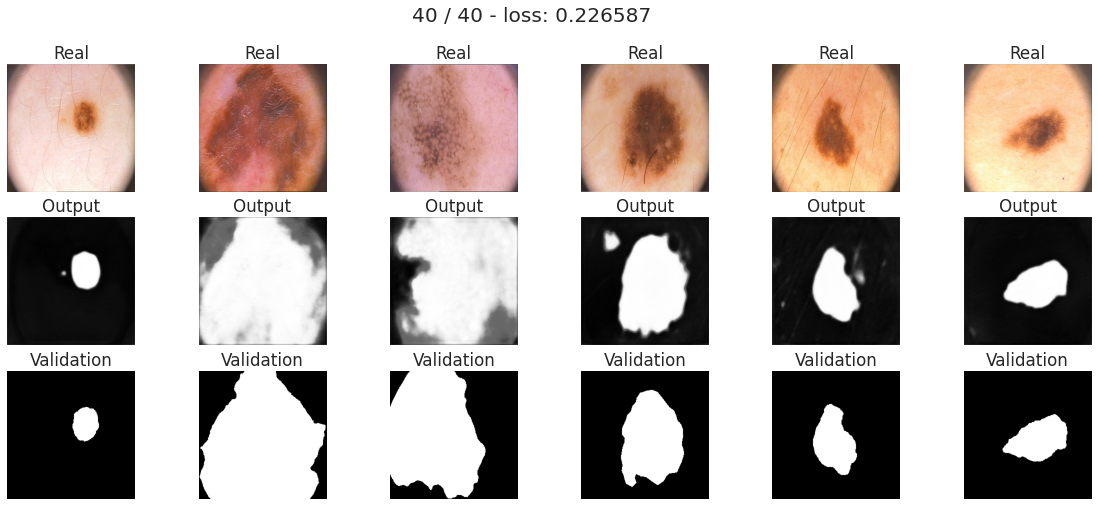

In [ ]:
model_Unet_dice_boundary = UNet().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet_dice_boundary.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)

train_loss_dice_boundary_Unet, val_loss_dice_boundary_Unet, scores_dice_boundary_Unet = train(
    model_Unet_dice_boundary, optimaizer, dice_boundary_loss,
     max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet_dice_boundary)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_dice_boundary_Unet, val_loss_dice_boundary_Unet)

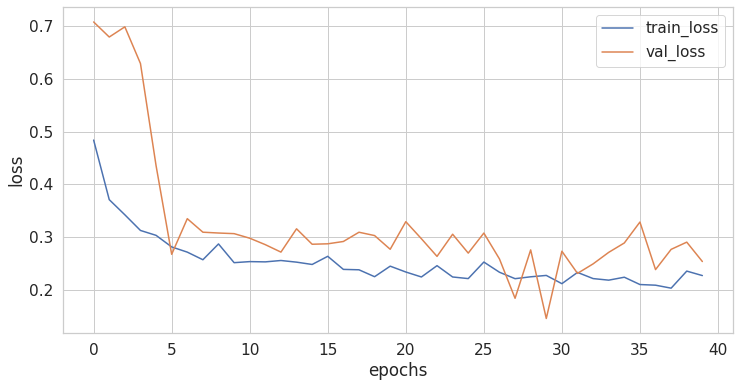

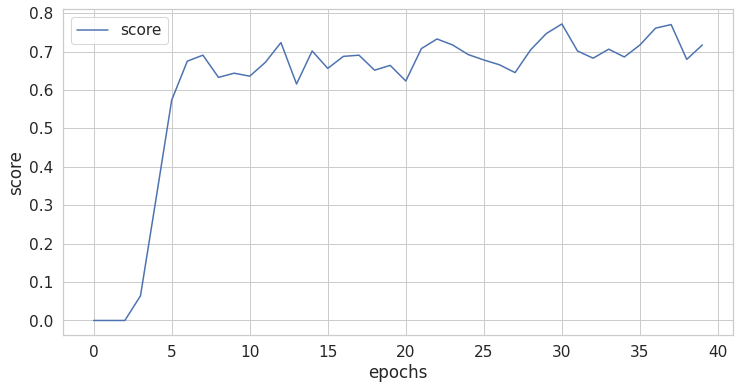

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_dice_boundary_Unet, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_dice_boundary_Unet = score_model(model_Unet_dice_boundary, iou_pytorch, data_val)
score_dice_boundary_Unet

0.6296875104308128

In [ ]:
models_score.loc[1, 'DiceBLoss_score'] = score_dice_boundary_Unet
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.729687         0.629688
2   UNet2       0.000000        0.000000         0.000000         0.000000

# **Unet2**

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool3 = nn.Conv2d(512, 512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 32 -> 64

        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2) # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2) # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(p3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3


### **Unet2 BCELoss**

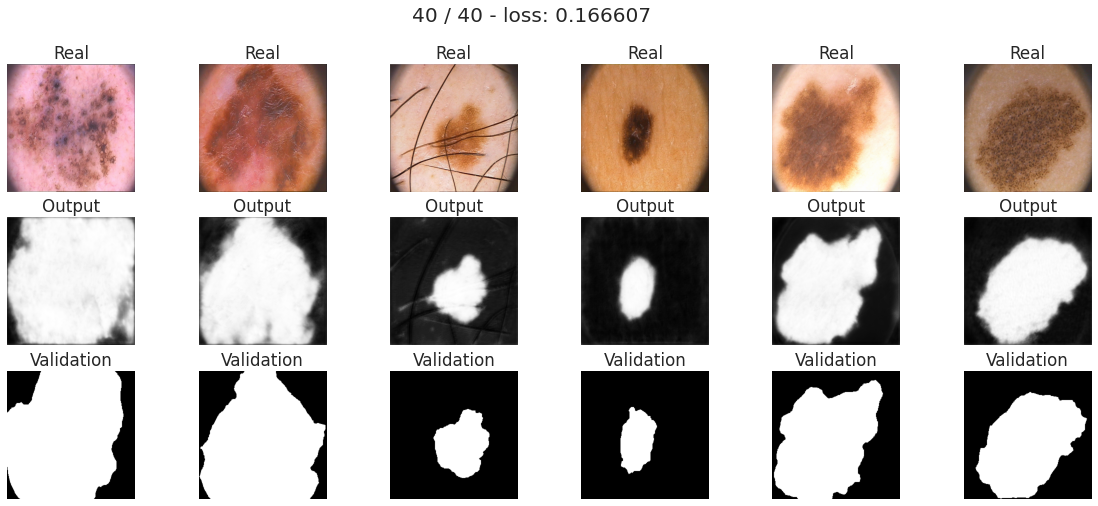

In [ ]:
model_Unet2_BCE = UNet2().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet2_BCE.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)

train_loss_bce_Unet2, val_loss_bce_Unet2, scores_bce_Unet2 = train(
    model_Unet2_BCE, optimaizer, bce_loss,
     max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet2_BCE)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_bce_Unet2, val_loss_bce_Unet2)

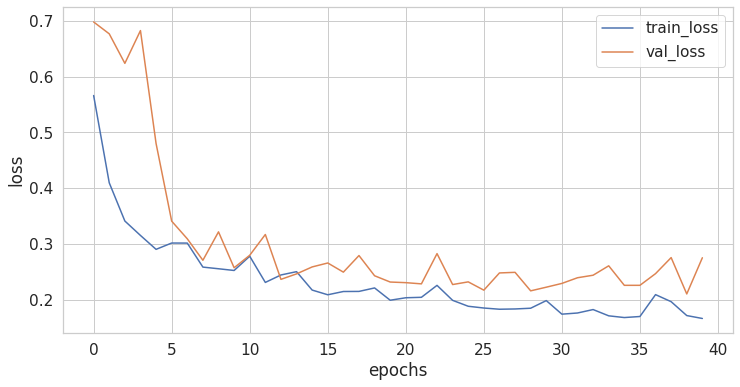

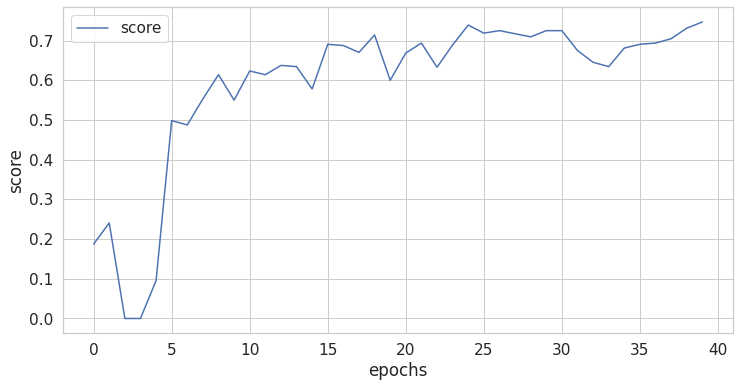

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_bce_Unet2, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_BCE_Unet2 = score_model(model_Unet2_BCE, iou_pytorch, data_val)
score_BCE_Unet2

0.7468750327825546

In [ ]:
models_score.loc[2, 'BCELoss_score'] = score_BCE_Unet2
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.729687         0.629688
2   UNet2       0.746875        0.000000         0.000000         0.000000

### **Unet2 Dice coefficient**

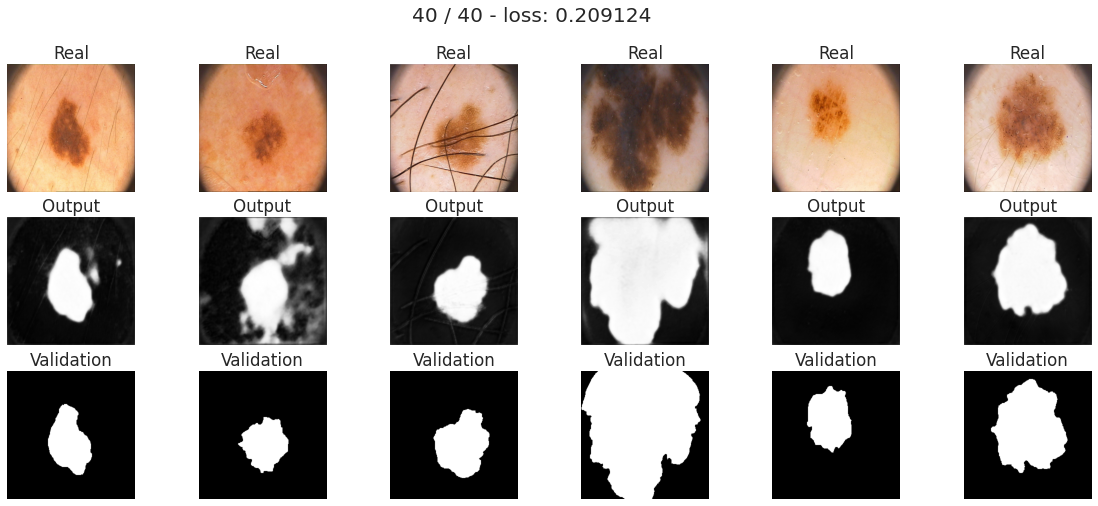

In [ ]:
model_Unet2_dice = UNet2().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet2_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_dice_Unet2, val_loss_dice_Unet2, scores_dice_Unet2 = train(
    model_Unet2_dice, optimaizer, dice_loss,
     max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet2_dice)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_dice_Unet2, val_loss_dice_Unet2)

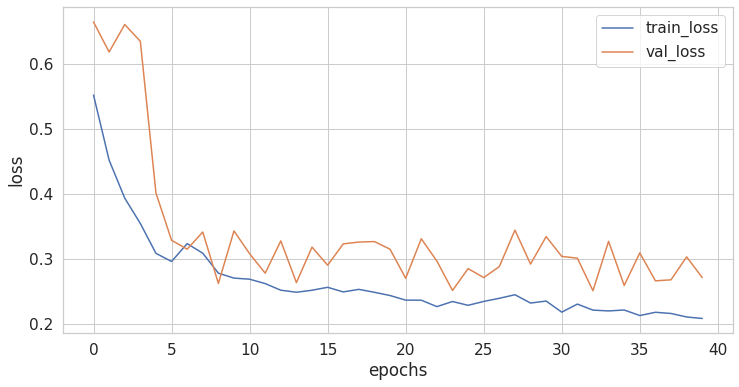

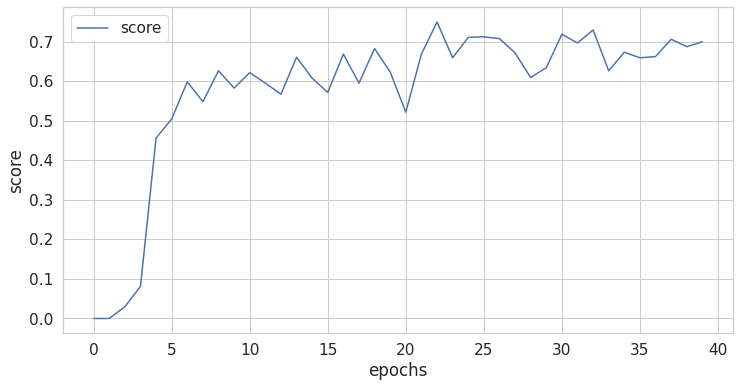

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_dice_Unet2, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_dice_Unet2 = score_model(model_Unet2_dice, iou_pytorch, data_val)
score_dice_Unet2

0.6781250238418579

In [ ]:
models_score.loc[2, 'DiceLoss_score'] = score_dice_Unet2
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.729687         0.629688
2   UNet2       0.746875        0.678125         0.000000         0.000000

### **Unet2 Focal loss**

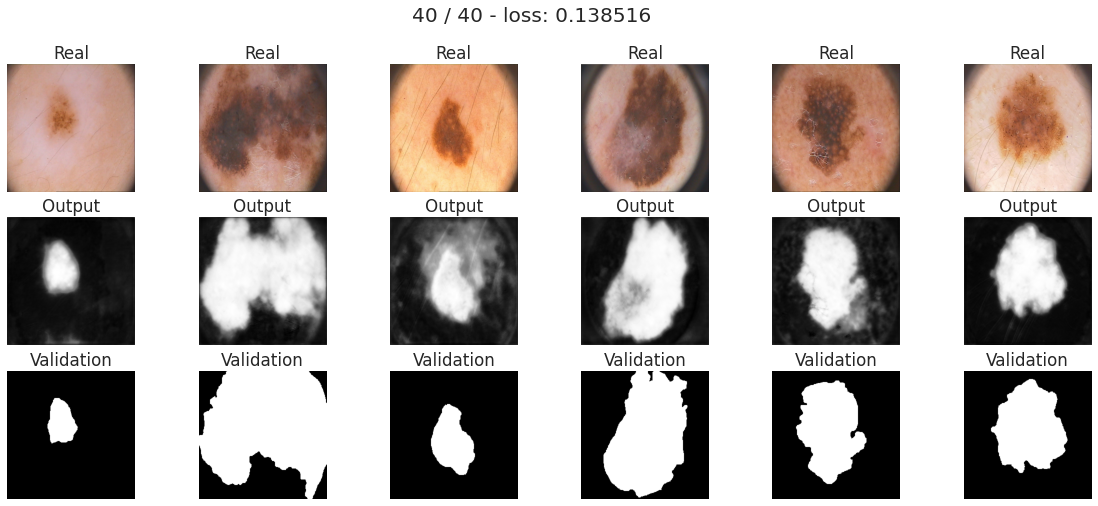

In [ ]:
model_Unet2_focal = UNet2().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet2_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)
train_loss_focal_Unet2, val_loss_focal_Unet2, scores_focal_Unet2 = train(
    model_Unet2_focal, optimaizer, focal_loss,
     max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet2_focal)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_focal_Unet2, val_loss_focal_Unet2)

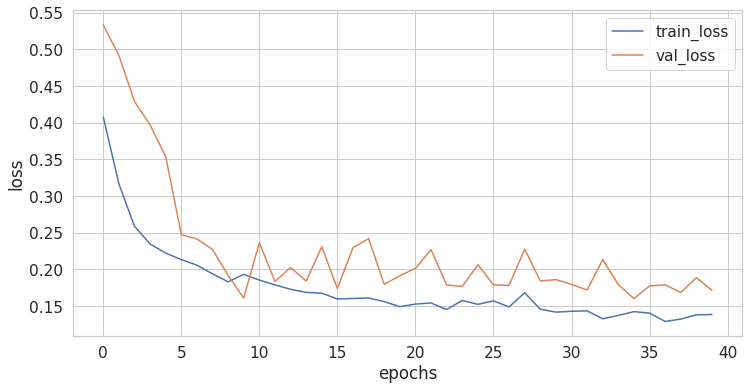

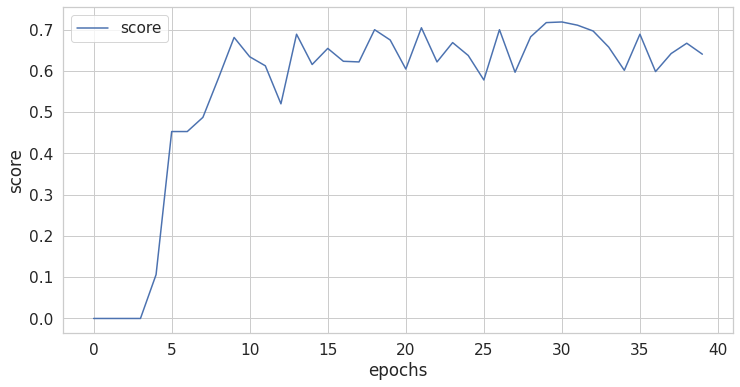

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_focal_Unet2, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_focal_Unet2 = score_model(model_Unet2_focal, iou_pytorch, data_val)
score_focal_Unet2

0.7171875387430191

In [ ]:
models_score.loc[2, 'FocalLoss_score'] = score_focal_Unet2
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.729687         0.629688
2   UNet2       0.746875        0.678125         0.717188         0.000000

### **Unet2 Dice boundary loss**

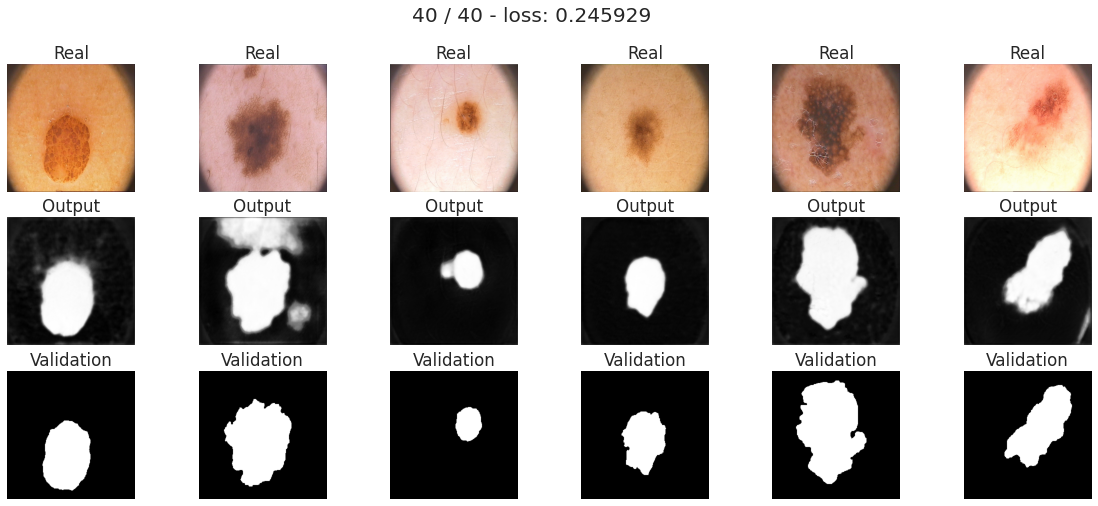

In [ ]:
model_Unet2_dice_boundary = UNet2().to(device)

max_epochs = 40

optimaizer = torch.optim.Adam(model_Unet2_dice_boundary.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimaizer, gamma=0.95)

train_loss_dice_boundary_Unet2, val_loss_dice_boundary_Unet2, scores_dice_boundary_Unet2 = train(
    model_Unet2_dice_boundary, optimaizer, dice_boundary_loss,
     max_epochs, data_tr, data_val, scheduler)

In [ ]:
models.append(model_Unet2_dice_boundary)

In [ ]:
train_loss, val_loss = loss_transform(train_loss_dice_boundary_Unet2, val_loss_dice_boundary_Unet2)

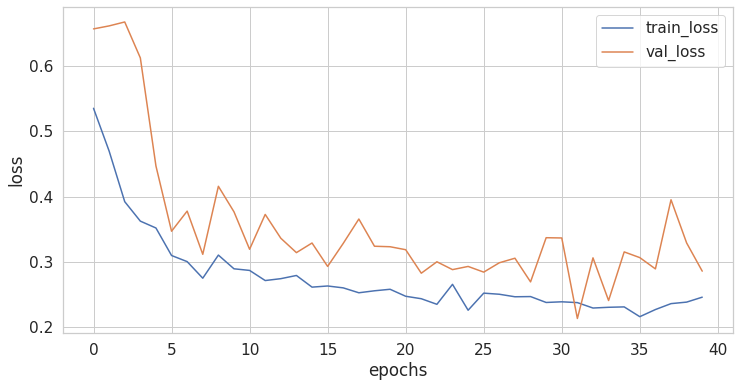

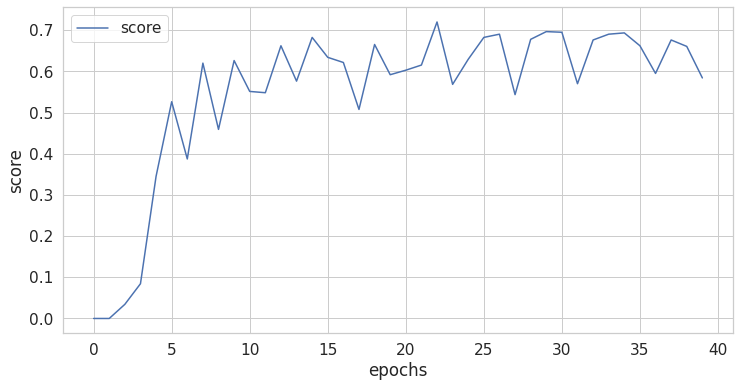

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(scores_dice_boundary_Unet2, label='score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_dice_boundary_Unet = score_model(model_Unet2_dice_boundary, iou_pytorch, data_val)
score_dice_boundary_Unet

0.5515625029802322

In [ ]:
models_score.loc[2, 'DiceBLoss_score'] = score_dice_boundary_Unet
models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.729687         0.629688
2   UNet2       0.746875        0.678125         0.717188         0.551563

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [ ]:
models_test = [score_model(mod, iou_pytorch, data_ts) for mod in models]
BCE, Dice, Focal, DiceBound = [], [], [], []
for i in range(len(models_test)):
  if i in (0, 4, 8):
    BCE.append(models_test[i])
  elif i in (1, 5, 9):
    Dice.append(models_test[i])
  elif i in (2, 6, 10):
    Focal.append(models_test[i])
  else:
    DiceBound.append(models_test[i])

### **Выводы**

В ходе изучения функций потерь были обучены 12 моделей с одинаковыми гиперпараметрами и разными функциями потерь, были построенны графики с метриками 'loss' и 'score' на валидационной выборке (выше в ноутбуке), также с помощью вывода изображений во время обучения модели можно следить за сходимостью результатов.
Метрика 'score' была занесена в таблицу для валидационной и для тествой выборки, построенны 2 гистограммы так же по метрике 'score' для валидации и теста.

Все функции потерь приводили к обучению модели, результаты по разным функциям потерь с разными архитектурами отличается не столь значимо.

Лучший результат на валидационной выборке показала модель SegNet с функцией потерь 'DiceLoss'.

На тестовой выборке лучше всего показала себя функция 'DiceBoundary'.

In [ ]:
# результаты на валидационной выборке по разным моделям и с разными функциями потерь

models_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.639063        0.757813         0.628125         0.684375
1    UNet       0.614063        0.693750         0.729687         0.629688
2   UNet2       0.746875        0.678125         0.717188         0.551563

In [ ]:
# результаты на тестовой выборке по разным моделям и с разными функциями потерь

models_test_score = pd.DataFrame({'name': ['Segnet', 'UNet', 'UNet2'],
                             'BCELoss_score': BCE,
                             'DiceLoss_score': Dice,
                             'FocalLoss_score': Focal,
                             'DiceBLoss_score': DiceBound})
models_test_score

name  BCELoss_score  DiceLoss_score  FocalLoss_score  DiceBLoss_score
0  Segnet       0.673438        0.775000         0.700000         0.803125
1    UNet       0.682813        0.779688         0.734375         0.675000
2   UNet2       0.771875        0.610938         0.753125         0.743750

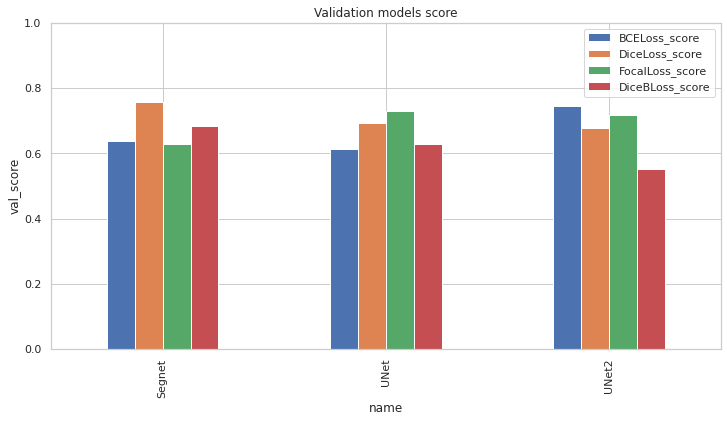

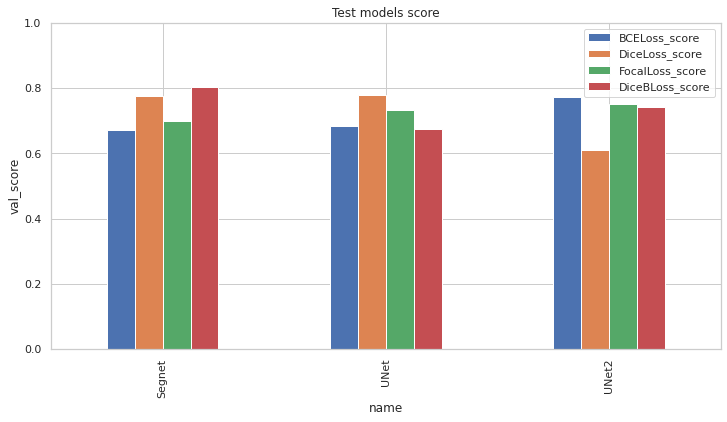

In [ ]:
sns.set(style="whitegrid", font_scale=1)
models_score.plot(x='name', ylabel='val_score',ylim=(0, 1), kind='bar', figsize=(12, 6), title='Validation models score')
models_test_score.plot(x='name', ylabel='val_score',ylim=(0, 1), kind='bar', figsize=(12, 6), title='Test models score');

Ник на Kaggle: Ilya Terkin

Team Name: Илья_Федотов_405593976

Stepik ID: 405593976
